In [1]:
import os
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# LED PATTERNS for the digits 0 to 9
LED_BLUE_PRINT = np.array([[1,1,1,1,1,1,0],
                     [0,1,1,0,0,0,0],
                     [1,1,0,1,1,0,1],
                     [1,1,1,1,0,0,1],
                     [0,0,1,0,0,1,1],
                     [1,0,1,1,0,1,1],
                     [1,0,1,1,1,1,1],
                     [1,1,1,0,0,0,0],
                     [1,1,1,1,1,1,1],
                     [1,1,1,1,0,1,1]
                    ])

# All cases essential data files
TRAIN_DATA_FILE = "train_data.csv"
TEST_DATA_FILE = "test_data.csv"
ALL_CASES_INPUT_DATA = "all_cases_input_data.csv"
ALL_CASES_PREDICTIONS = "all_cases_predictions.csv"
ALL_CASES_PREDICTIONS_COLUMS = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

# LEDS and DIGITS arr to refer
LEDS_ARR = ["A", "B", "C", "D", "E", "F", "G"]
DIGITS = ["Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]


In [2]:
# Generic data loading function
def load_data(file=TRAIN_DATA_FILE, header=True):
    csv_path = os.path.join("", file)
    if header:
        return pd.read_csv(csv_path)
    else:
        return pd.read_csv(csv_path, header=None)

In [3]:
# Load the train and test data
# Drop DIGIT column and treat it as labels
train_data = load_data(TRAIN_DATA_FILE)
train_labels = train_data["DIGIT"]
train_data.drop("DIGIT", axis=1, inplace=True)

test_data = load_data(TEST_DATA_FILE)
test_labels = test_data["DIGIT"]
test_data.drop("DIGIT", axis=1, inplace=True)

In [4]:
# Load all cases input data
all_cases_input_data = load_data(ALL_CASES_INPUT_DATA)

In [5]:
# Find out the optimal dimensions using PCA
# Return dimension where the minimum variance between the features drop to thres value
from sklearn.decomposition import PCA

def get_dims_variances(x, minDim, tol=None, thres=0.01):
    dims = []
    variances = []
    optimum_dim = minDim
    prev_min_variance = None
    dim = minDim
    
    while(True):
        pca = PCA(n_components=dim)
        pca.fit(x)
        variance = np.array(pca.explained_variance_ratio_)
        min_variance = variance.min()
        
        dims.append(dim)
        variances.append(min_variance)
        
        if tol != None and prev_min_variance != None and min_variance + tol > prev_min_variance:
            break

        else:
            if prev_min_variance != None and min_variance < thres:
                break
                
        prev_min_variance = min_variance
        optimum_dim = dim
        dim = dim + 1

    return dims, variances, optimum_dim

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# Data processing routine

def process_data(x, y, poly_features=None, pca=None, OPTIMUM_DIMENSION=None, imputer=None, scalar=None):
    training_features = x.copy()
    testing_features = y.copy()
    
    if imputer == None:
        imputer = Imputer(strategy="median")
        imputer.fit(training_features)
        
    training_features = imputer.transform(training_features)
    testing_features = imputer.transform(testing_features)
    
    if scalar == None:
        scalar = StandardScaler()
        scalar.fit(training_features)
        
    training_features = scalar.transform(training_features)
    testing_features = scalar.transform(testing_features)
    
    if poly_features == None:
        poly_features = PolynomialFeatures(degree=2, include_bias=False)
        poly_features.fit(training_features)
        
    training_features = poly_features.transform(training_features)
    testing_features = poly_features.transform(testing_features)

    if OPTIMUM_DIMENSION == None:
        dims, variances, OPTIMUM_DIMENSION = get_dims_variances(x=training_features, minDim=2, thres=0.005)
        print("Optimum Dimensions: ", OPTIMUM_DIMENSION)
        plt.plot(dims, variances)
        plt.show()
        dim_df = pd.DataFrame()
        dim_df["DIM"] = dims
        dim_df["VAR"] = variances

    if pca == None:  
        pca = PCA(random_state=42, n_components=OPTIMUM_DIMENSION)
        pca.fit(training_features)
        
    training_features = pca.transform(training_features)
    testing_features = pca.transform(testing_features)
    
    return training_features, testing_features, poly_features, pca, OPTIMUM_DIMENSION, imputer, scalar

Optimum Dimensions:  9


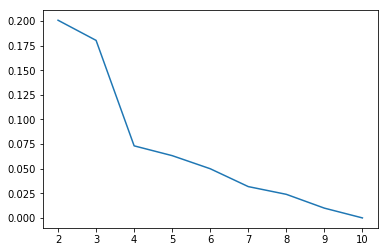

In [7]:
training_features, testing_features, poly_features, pca, OPTIMUM_DIMENSION, imputer, scalar = process_data(x=train_data, y=test_data)

training_labels = train_labels.values
testing_labels = test_labels.values

In [8]:
# SGD Classifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone

X_train = training_features
Y_train = training_labels
X_test = testing_features
Y_test = testing_labels

gridSearch = False
if gridSearch:
    parameters = {
                  'n_iter' : [2,3,4,5,6,7,8,9,10]
                 }
    clf = GridSearchCV(SGDClassifier(random_state=42), parameters)
    clf.fit(X_train, Y_train)
    print("\nBest params: ", clf.best_params_)

sgd_clf = SGDClassifier(random_state=42, penalty="elasticnet", loss='log', n_iter=3)
cross_val_scores = cross_val_score(clone(sgd_clf), X_train, Y_train, cv=3, scoring="accuracy")
print("Cross Val Scores on training set\n", cross_val_scores)

sgd_clf.fit(X_train, Y_train)
print("\n\nAccuracy on testing data set\n", sum(Y_test == sgd_clf.predict(X_test)) / len(Y_test))

Cross Val Scores on training set
 [1. 1. 1.]


Accuracy on testing data set
 0.35714285714285715


/Users/yogesh/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/yogesh/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/yogesh/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/yogesh/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [9]:
# KNeighbors Classifier
from sklearn.neighbors import KNeighborsClassifier 

X_train = training_features
Y_train = training_labels
X_test = testing_features
Y_test = testing_labels

gridSearch = False
if gridSearch:
    parameters = {'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'n_neighbors' : [2,3,4,5,6,7,8,9,10],
                  'weights' : ['uniform', 'distance']
                 }
    clf = GridSearchCV(KNeighborsClassifier(), parameters)
    clf.fit(X_train, Y_train)
    print("\nBest params: ", clf.best_params_)

knn_clf = KNeighborsClassifier(algorithm='auto', n_neighbors=2, weights='uniform')
print("\nCross Val Scores on training set\n", cross_val_score(clone(knn_clf), X_train, Y_train, cv=3, scoring="accuracy"))

knn_clf.fit(X_train, Y_train)
print("\n\nAccuracy on testing data set\n", sum(Y_test == knn_clf.predict(X_test)) / len(Y_test))


Cross Val Scores on training set
 [1. 1. 1.]


Accuracy on testing data set
 0.5


In [10]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier 

X_train = training_features
Y_train = training_labels
X_test = testing_features
Y_test = testing_labels

gridSearch = True
if gridSearch:
    parameters = {
                  'n_estimators' : [2,3,4,5,6,7,8,9,10]
                 }
    clf = GridSearchCV(RandomForestClassifier(random_state=42), parameters)
    clf.fit(X_train, Y_train)
    print("\nBest params: ", clf.best_params_)


forest_clf = RandomForestClassifier(random_state=42, oob_score=True, n_estimators=7)
print("Cross Val Scores on training set\n", cross_val_score(clone(forest_clf), X_train, Y_train, cv=3, scoring="accuracy"))

forest_clf.fit(X_train, Y_train)
print("\n\nAccuracy on testing data set\n", sum(Y_test == forest_clf.predict(X_test)) / len(Y_test))



Best params:  {'n_estimators': 3}
Cross Val Scores on training set
 [1. 1. 1.]


Accuracy on testing data set
 0.42857142857142855


In [11]:
# MLP Classifier
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer

X_train = training_features
Y_train = training_labels
X_test = testing_features
Y_test = testing_labels
batch_size = 1
num_classes = 10
epochs = 20

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0005),
              metrics=['accuracy'])

binarizer = LabelBinarizer()
binarizer.fit(Y_train)
Y_train = binarizer.transform(Y_train)
Y_test = binarizer.transform(Y_test)

history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))

score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test accuracy/loss ratio:', score[1] / score[0])

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               5120      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 10,250
Trainable params: 10,250
Non-trainable params: 0
_________________________________________________________________
Train on 30 samples, validate on 28 samples
Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 2.0081 - acc: 0.4667 - val_loss: 2.0174 - val_acc: 0.2857
Epoch 2/20
30/30 [==============================] - 0s 2ms/step - loss: 1.2770 - acc: 1.0000 - val_loss: 1.8667 - val_acc: 0.3571
Epoch 3/20
30/30 [==============================] - 0s 3ms/step - loss: 0.8288 - acc: 1.0000 - val_loss: 1.7508 - val_acc: 0.3571
Epoch 4/20
30/30 [==============================] - 0s 2ms/step - loss: 0.5346 - acc: 1.0000 - val_

In [12]:
def inverse_leds(leds):
    leds_copy = leds.copy()
    leds_copy = np.add(leds_copy, 1)
    leds_copy = np.fmod(leds_copy, 2)
    return leds_copy

In [13]:
from sklearn.utils.extmath import softmax
def boost_by_inv_logic(preds, preds_inv, X):
    l = len(X)
    for indx in range(l):
        pred = preds[indx]
        pred_inv = preds_inv[indx]
        x = X[indx]
    
        for led_indx in range(len(LED_BLUE_PRINT)):
            seg = LED_BLUE_PRINT[led_indx]
            if np.min(seg - x) < 0:
                pred[led_indx] = 0
        
        #pred_inv = np.add(pred_inv, 0.01)
        #preds[indx] = np.divide(pred, pred_inv)
        preds[indx] = pred
        
    return softmax(preds)

In [14]:
def subsume_entity_affinity(led_label, affinity_calculation_result, pred):
    entity_affinity = affinity_calculation_result['data'][led_label]['entityAffinity']
    for indx in range(len(DIGITS)):
        pred[indx] += entity_affinity[DIGITS[indx]]
    
    return pred

In [15]:
def get_all_cases_predictions_affinity(all_cases_features, affinity_calculation_result):
    all_cases_features_values = all_cases_features.values
    affinity_preds = []
    for all_cases_features_value in all_cases_features_values:
        
        active_single_leds = []
        for indx in range(len(all_cases_features_value)):
            if all_cases_features_value[indx] == 0: continue
            active_single_leds.append(LEDS_ARR[indx])
        
        pred = [0.0 for x in range(10)]
        for indx in range(len(active_single_leds)):
            led_label = active_single_leds[indx]
            pred = subsume_entity_affinity(led_label, affinity_calculation_result, pred)
            
            out_indx = indx + 1
            while out_indx < len(active_single_leds):
                pred = subsume_entity_affinity(led_label + active_single_leds[out_indx], affinity_calculation_result, pred)
                out_indx += 1
            
        pred = np.divide(pred, sum(pred) + 0.1)
        pred = np.multiply(pred, 100)
        affinity_preds.append(pred)
        
    affinity_preds = np.array(affinity_preds)
    affinity_df = pd.DataFrame(affinity_preds, columns=ALL_CASES_PREDICTIONS_COLUMS)
    affinity_df["TYPE"] = "AFFINITY";
        
    return affinity_df

In [16]:
def get_all_cases_predictions(all_cases_features):
    all_cases_features_inv = inverse_leds(all_cases_features)
    
    preds_df = pd.DataFrame(columns=ALL_CASES_PREDICTIONS_COLUMS)
    preds_df["TYPE"] = None
    
    all_cases_features_,_,_,_,_,_,_ = process_data(x=all_cases_features, y=all_cases_features, 
                                              poly_features=poly_features, pca=pca, 
                                              OPTIMUM_DIMENSION=OPTIMUM_DIMENSION, imputer=imputer, scalar=scalar)
    
    all_cases_features_inv_,_,_,_,_,_,_ = process_data(x=all_cases_features_inv, y=all_cases_features_inv, 
                                              poly_features=poly_features, pca=pca, 
                                              OPTIMUM_DIMENSION=OPTIMUM_DIMENSION, imputer=imputer, scalar=scalar)
    
    preds = model.predict(all_cases_features_.copy())
    preds_inv = model.predict(all_cases_features_inv_.copy())               
    mlp_preds = boost_by_inv_logic(preds, preds_inv, all_cases_features.copy().values)
    mlp_preds = np.multiply(mlp_preds, 100)
    mlp_df = pd.DataFrame(mlp_preds, columns=ALL_CASES_PREDICTIONS_COLUMS)
    mlp_df["TYPE"] = "MLP"
    preds_df = preds_df.append(mlp_df)
    
    
    preds = forest_clf.predict_proba(all_cases_features_.copy())
    preds_inv = forest_clf.predict_proba(all_cases_features_inv_.copy()) 
    rf_preds = boost_by_inv_logic(preds, preds_inv, all_cases_features.copy().values)
    rf_preds = np.multiply(rf_preds, 100)
    rf_df = pd.DataFrame(rf_preds, columns=ALL_CASES_PREDICTIONS_COLUMS)
    rf_df["TYPE"] = "RF";
    preds_df = preds_df.append(rf_df)
    
    
    preds = knn_clf.predict_proba(all_cases_features_.copy())
    preds_inv = knn_clf.predict_proba(all_cases_features_inv_.copy()) 
    knn_preds = boost_by_inv_logic(preds, preds_inv, all_cases_features.copy().values)
    knn_preds = np.multiply(knn_preds, 100)
    knn_df = pd.DataFrame(knn_preds, columns=ALL_CASES_PREDICTIONS_COLUMS)
    knn_df["TYPE"] = "KNN"
    preds_df = preds_df.append(knn_df)
    
    
    preds = sgd_clf.predict_proba(all_cases_features_.copy())
    preds_inv = sgd_clf.predict_proba(all_cases_features_inv_.copy()) 
    sgd_preds = boost_by_inv_logic(preds, preds_inv, all_cases_features.copy().values)
    sgd_preds = np.multiply(sgd_preds, 100)
    sgd_df = pd.DataFrame(sgd_preds, columns=ALL_CASES_PREDICTIONS_COLUMS)
    sgd_df["TYPE"] = "SGD"
    preds_df = preds_df.append(sgd_df)
    
    
    with open('affinity-session-data/Led7-777/AFFINITY_CALCULATION.txt', 'r') as myfile:
        affinity_calculation_result = json.loads(myfile.read().replace('\n', ''))
        
    affinity_df = get_all_cases_predictions_affinity(all_cases_features.copy(), affinity_calculation_result)
    preds_df = preds_df.append(affinity_df)

    return preds_df

In [17]:
all_cases_features = load_data(ALL_CASES_INPUT_DATA)
all_cases_predictions_df = get_all_cases_predictions(all_cases_features.copy())

In [18]:
all_cases_predictions_df.head()

,0,1,2,3,4,5,6,7,8,9,TYPE
0,9.081184,11.848742,11.566585,9.064027,9.832640,9.050720,9.030071,9.098377,12.094970,9.332682,MLP
1,9.112054,9.112054,11.797271,9.303668,14.418475,9.181708,9.207438,9.112054,9.384938,9.370337,MLP
2,9.358452,9.201366,9.201366,9.201366,16.180779,9.319937,9.301088,9.201366,9.692392,9.341880,MLP
3,8.668295,8.668295,8.668295,8.668295,21.848528,8.707028,8.699068,8.668295,8.694063,8.709834,MLP
4,9.628125,9.549620,13.880207,9.549620,9.549620,9.549620,9.571830,9.549620,9.622121,9.549620,MLP


In [19]:
all_cases_predictions_df.tail()

,0,1,2,3,4,5,6,7,8,9,TYPE
123,12.030609,2.723732,10.007809,11.155872,9.298306,12.064893,9.244974,5.307467,13.675800,14.485777,AFFINITY
124,15.817122,4.818602,12.107172,8.373888,4.592605,7.299903,12.094505,8.147891,17.131105,9.610539,AFFINITY
125,13.225714,4.150952,12.573333,9.627619,6.332857,9.439048,11.830952,6.064286,16.245238,10.505238,AFFINITY
126,15.740326,3.483300,11.446558,8.040400,6.605651,8.457538,12.138456,6.054228,16.609366,11.419415,AFFINITY
127,13.627094,3.144274,11.864600,9.141039,7.666044,10.124250,11.920315,4.739269,15.886015,11.883529,AFFINITY


In [20]:
all_cases_predictions_df.to_csv(ALL_CASES_PREDICTIONS, sep=',', index_label="id")